In [2]:
# imports
import matplotlib.path as mpath
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# different polys
poly = np.array(([0, 0.23], [0.1, 0.23], [0.1, 0.13], [0.07, 0.13], [0.07, 0.1], [0.1, 0.1], [0.1, 0], [0, 0], [0, 0.1], [0.03, 0.1], [0.03, 0.13], [0, 0.13], [0, 0.23]))
#poly = np.array([[0, 0], (0, -1), (0.5, -0.6), (1, -1), [1, 0], [0, 0]])
#poly = np.array([[0, 0.5], [0.1, 0.5], [0.065, 0], [0.035, 0], [0, 0.5]])

In [4]:
def circ_points(x, y, r, n=100):
    """Create np array to draw circles"""
    theta = np.linspace(0, 2*np.pi, n)
    a = r * np.cos(theta) + x
    b = r * np.sin(theta) + y
    return a, b

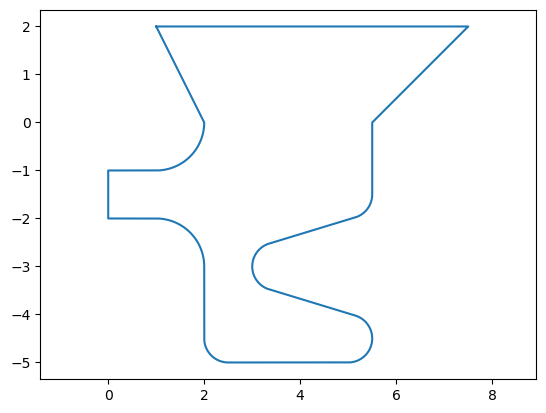

In [5]:
# complex poly
n = 200
f1 = np.array([[1, 2]])
f2 = np.column_stack(circ_points(1, 0, 1, n))[:3*n//4:-1]
f3 = np.array([[0, -1], [0, -2]])
f4 = np.column_stack(circ_points(1, -3, 1, n))[n//4::-1]
f5 = np.column_stack(circ_points(2.5, -4.5, 0.5, n))[n//2:3*n//4]
f6 = np.column_stack(circ_points(5, -4.5, 0.5, n))[3*n//4:-1]
f7 = np.column_stack(circ_points(5, -4.5, 0.5, n))[1:n//5]
f8 = np.column_stack(circ_points(3.5, -3, 0.5, n))[14*n//20:6*n//20:-1]
f9 = np.column_stack(circ_points(5, -1.5, 0.5, n))[4*n//5:]
f0 = np.array([[5.5, 0], [7.5, 2], [1, 2]])

poly = np.concatenate((f1, f2, f3, f4, f5, f6, f7, f8, f9, f0))

plt.axis('equal')
plt.plot(poly[:, 0], poly[:, 1])

In [6]:
# get line segments
poly_lines = np.column_stack((poly[:-1], poly[1:]))
l1x, l1y, l2x, l2y = poly_lines[:, 0], poly_lines[:, 1], poly_lines[:, 2], poly_lines[:, 3]

# define eps environment
EPS = 1e-9
EPS_BOX = np.array(((0, 0), (0, EPS), (EPS, 0), (0, -EPS), (-EPS, 0)))

In [7]:
def point_grid(poly, step=0.01, zero_level=True):
    """Generate a grid and return all coords in array of 2-tuples with step between points"""
    # all x-/ y-values
    top = 0
    if not zero_level:
        top =  poly[:, 1].max()
    x_vals = np.arange(poly[:, 0].min() - 2 * step, poly[:, 0].max() + 2 * step, step)  # np.arange(0, 10.0001, 0.1)
    y_vals = np.arange(poly[:, 1].min() - 2 * step, top + 2 * step, step)

    # Create 2D grid
    X, Y = np.meshgrid(x_vals, y_vals)  # both shape (101, 101)

    # reshape into (x1, y1), ..., (xn, yn)
    x_grid = X.flatten()
    y_grid = Y.flatten()
    return np.column_stack((x_grid, y_grid))

def inside_points(poly, flat_grid=None):
    """For all given points, check whether they're inside the polygon"""
    # create a new grid if undefined
    if flat_grid is None:
        flat_grid = point_grid(poly)
    # use mpath to check if a point (including its closest surrounding)
    # is inside the polygon and mask the grid with the result
    mpath_poly = mpath.Path(poly)
    bools = np.ones_like(flat_grid[:, 0], dtype=bool)
    for i in range(len(flat_grid)):
        bools[i] = mpath_poly.contains_points(flat_grid[i]+EPS_BOX).sum() == 5
    return flat_grid[bools]

In [8]:
# generate grid & inside points for our polygon
grid = point_grid(poly, 0.02)
inside = inside_points(poly, grid)

In [9]:
def get_random_point(inside):
    """Get a random point from the inside array"""
    return inside[np.random.randint(0, len(inside), 1)][0]

def get_point(inside, i):
    """Get the i-th point from the inside array"""
    if i >= len(inside):
        return None, None
    return inside[i]

def get_closest(x, y, a, b, c, d):
    """Get the closest point on the edge of the polygon"""
    # calculate the factor r that a + r*ab is on the lot through x|y onto the line segment
    rr = -(-x*c + a*c + a*x - a*a + b*y - b*b - d*y + b*d) / (c*c - 2*a*c + a*a + b*b - 2*b*d + d*d)
    # the line only goes from a (r=0) to b (r=1)
    rrs = np.minimum(1, np.maximum(0, rr))
    # get the closest point for all line segments
    foot_points = np.array([a + rrs * (c - a), b + rrs * (d - b)])
    # return the closest of those
    closest = np.argmin((foot_points[0]-x)**2 + (foot_points[1]-y)**2)
    return foot_points[:, closest]

def get_opp(x, y, u, v, aa, bb, cc, dd):
    """Get the point on the opposite side of a given polygon"""
    # not vectorized because too lazy/hard

    # solution point / "distance" arrays
    ll = []
    hh = []
    # iterate over the line segments
    for l in range(len(aa)):
        # redefine line segment for easier access
        a, b, c, d = aa[l], bb[l], cc[l], dd[l]
        # if parallel, this can't be correct
        if np.abs((x-u)*(d-b) - (y-v)*(c-a)) <= EPS:
            continue
        # calculate the h factor := the needed multiples of
        # xy-uv to cut the line segment
        h = ((v-b)*(c-a) - (u-a)*(d-b))/((x-u)*(d-b) - (y-v)*(c-a))
        # same point
        if h <= EPS:
            continue
        # calculate r := the needed multiples of the line segment
        # sometimes only one equation usable
        if np.abs(c - a) <= EPS:
            if np.abs(d - b) <= EPS:
                continue
            r = (v-b + h*(y-v))/(d-b)
        else:
            r = (u-a + h*(x-u))/(c-a)
        # if not in [0, 1], this does not actually cut the ls
        if not (0 <= r <= 1):
            continue
        # in case of a solution, save it
        ll.append(np.array([u+h*(x-u), v+h*(y-v)]))
        hh.append(h)
    if len(ll) == 0:
        raise Exception("No opposite point found")
    # return first opp point -> don't leave the polygon
    ind_min_h = np.argmin(hh)
    return np.array(ll)[ind_min_h]

def get_mid(x, y, u, v, o, p):
    """Get the middle point of the line between closest and opp"""
    k = ((o-u)**2 + (p-v)**2)/(2*((o-u)*(x-u)+(p-v)*(y-v)))
    return u + k*(x-u), v + k*(y-v)

In [10]:
def get_heuver_points(count, l1x, l1y, l2x, l2y, random=False):
    points = np.zeros((count, 3))
    for i in range(count):
        if random:
            x, y = get_random_point(inside) # random point
        else:
            x, y = get_point(inside, i*len(inside)//count)
        if x is None: break
        u, v = get_closest(x, y, l1x, l1y, l2x, l2y) # foot point
        o, p = get_opp(x, y, u, v, l1x, l1y, l2x, l2y) # opponent point
        m, n = (o+u)/2, (p+v)/2 # mid point
        f, g = get_closest(m, n, l1x, l1y, l2x, l2y)
        while not(np.isclose(u, f) and np.isclose(v, g) or np.isclose(o, f) and np.isclose(p, g)):
            o, p = f, g
            m, n = get_mid(x, y, u, v, o, p)
            f, g = get_closest(m, n, l1x, l1y, l2x, l2y)

        if n > 0: continue
        r = np.sqrt((m-u)**2 + (n-v)**2)

        if (f-u)**2 + (g-v)**2 < 0.01:
            continue
        points[i] = m, n, r
    return points[(points[:, 0] != 0) & (points[:, 1] != 0)]

In [11]:
def plot_points(poly, points, circles=True, savefig=None, *args, **kwargs):
    """Plot a larger number of points inside a polygon"""
    plt.axis('equal')
    plt.plot(poly[:, 0], poly[:, 1], color='grey')
    plt.scatter(points[:, 0], points[:, 1], s=1)
    if circles:
        for m, n, r in points:
            circ_x, circ_y = circ_points(m, n, r)
            plt.plot(circ_x, circ_y, color='grey', alpha=0.5)
    if savefig is not None:
        plt.savefig(savefig)


In [12]:
def get_step_plot(x=None, y=None, u=None, v=None, o=None, p=None,
                  m=None, n=None, circ=None, f=None, g=None):
    """Plot all parts until a certain variable isn't supplied anymore"""
    if x is None or y is None: return
    plt.plot(x, y, color='b', marker='o')
    if u is None or v is None: return
    plt.plot([x, u], [y, v], color='b')
    plt.plot(u, v, color='r', marker='o')
    if o is None or p is None: return
    plt.plot([x, o], [y, p], color='b', linestyle='--')
    plt.plot(o, p, color='g', marker='o')
    if m is None or n is None: return
    plt.plot(m, n, color='y', marker='o')
    if circ is None: return
    if circ == 'uv':
        circ_r = np.sqrt((m-u)**2 + (n-v)**2)
    elif circ == 'fg':
        circ_r = np.sqrt((m-f)**2 + (n-g)**2)
    circ_x, circ_y = circ_points(m, n, circ_r)
    plt.plot(circ_x, circ_y, color='grey', alpha=0.5)
    if f is None or g is None: return
    plt.plot([m, f], [n, g], color='y')
    plt.plot(f, g, color='orange', marker='o')

def plot_single_step(poly, *args, savefig=None, show=False):
    """Plot a single step in the Algorithm"""
    plt.axis('equal')
    box = poly[:, 0].min(), poly[:, 0].max(), poly[:, 1].min(), poly[:, 1].max()
    if box[1]-box[0] < (box[3]-box[2])*4/3:
        plt.ylim(box[2]-(box[3]-box[2])/20, box[3]+(box[3]-box[2])/20)
    plt.plot(poly[:, 0], poly[:, 1], color='grey')

    get_step_plot(*args)

    if savefig is not None:
        plt.savefig(savefig)
    if show:
        plt.show()
    plt.clf()

def plot_steps(x, y, show=True, fpath='polyplot'):
    """Plot all steps until the Algorithm terminates"""
    plot_single_step(poly, savefig=f"{fpath}-00.png", show=show)
    plot_single_step(poly, x, y, savefig=f"{fpath}-01.png", show=show)

    u, v = get_closest(x, y, l1x, l1y, l2x, l2y) # foot point
    plot_single_step(poly, x, y, u, v, savefig=f"{fpath}-02.png", show=show)

    o, p = get_opp(x, y, u, v, l1x, l1y, l2x, l2y) # opponent point
    plot_single_step(poly, x, y, u, v, o, p, savefig=f"{fpath}-03.png", show=show)

    m, n = (o+u)/2, (p+v)/2 # mid point
    plot_single_step(poly, x, y, u, v, o, p, m, n, savefig=f"{fpath}-04.png", show=show)
    plot_single_step(poly, x, y, u, v, o, p, m, n, 'uv', savefig=f"{fpath}-05.png", show=show)

    f, g = get_closest(m, n, l1x, l1y, l2x, l2y)
    plot_single_step(poly, x, y, u, v, o, p, m, n, 'uv', f, g, savefig=f"{fpath}-06.png", show=show)
    plot_single_step(poly, x, y, u, v, o, p, m, n, 'fg', f, g, savefig=f"{fpath}-07.png", show=show)

    f_alt, g_alt = o, p
    plot_count = 8
    while not(np.isclose(u, f) and np.isclose(v, g) or np.isclose(f_alt, f) and np.isclose(g_alt, g)):
        f_alt, g_alt = f, g
        m, n = get_mid(x, y, u, v, f, g)
        plot_single_step(poly, x, y, u, v, o, p, m, n, 'uv', f, g, savefig=f"{fpath}-{plot_count:02}.png", show=show)
        f, g = get_closest(m, n, l1x, l1y, l2x, l2y)
        plot_single_step(poly, x, y, u, v, o, p, m, n, 'fg', f, g, savefig=f"{fpath}-{plot_count+1:02}.png", show=show)
        plot_count = plot_count + 2

In [95]:
points = get_heuver_points(2000, l1x, l1y, l2x, l2y)

In [96]:
cur = np.argmax(points[:, 1])
not_in_use = np.zeros(points.shape[0], dtype=int)
order = np.zeros(points.shape[0], dtype=int)
i = 0
closest_point_diff_path = None
closest_point_this_path = None
"""
while True:
    while True:
        order[i] = cur
        not_in_use[cur] = 1
        dists = (points[cur, 0]-points[:, 0])**2 + (points[cur, 1]-points[:, 1])**2
        next = np.argmin(dists + not_in_use*10)
        if dists[next] >= 0.01: break
        cur = next
        i += 1
    plt.plot(points[not_in_use>=.5, 0], points[not_in_use>=.5, 1], color='red')
    plot_points(poly, points, circles=False)
    plt.show()
    for pt in np.arange(points.shape[0]):
        if not_in_use[pt]==0: continue
        dists = (points[pt, 0]- points[:, 0])**2 + (points[pt, 1]-points[:, 1])**2
        closest = np.argmin(dists + not_in_use*10)
        # no non-chosen point near enough
        if dists[closest] >= 0.01: continue
        # first time a non-chosen point is near enough
        # save that point
        if closest_point_diff_path is None:
            closest_point_diff_path = closest
            closest_point_this_path = pt
            continue
        # if this is nearer, save it, otherwise continue
        if (points[closest_point_diff_path, 0]-points[pt, 0])**2 + (points[closest_point_diff_path, 1]-points[pt, 1])**2 < dists[closest]:
            closest_point_diff_path = closest
            closest_point_this_path = pt
    if closest_point_diff_path is None: break
    cur = closest_point_diff_path
    closest_point_diff_path = None
    closest_point_this_path = None
    """

    #"""


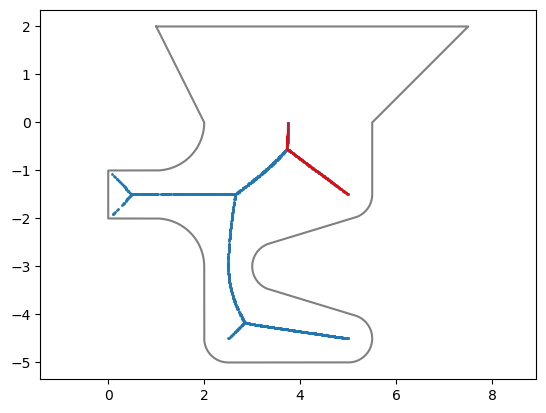

In [97]:
plt.plot(points[not_in_use>=.5, 0], points[not_in_use>=.5, 1], color='red')
plot_points(poly, points, circles=False)

In [26]:
#plot_points(poly, points)

<Figure size 640x480 with 0 Axes>

In [80]:
sum(not_in_use)

np.int64(164)